## ВКР: анализ данных

Автоматизация подбора персонала

Копчев Владислав, БПМИ197

В данном ноутбуке предобработанные в ноутбуке `preprocessing.ipynb` данные мы будем анализировать и делать из них полезные для принятия HR-решений выводы.

### Библиотеки

Импорт библиотек:

In [4]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select
# !pip install transliterate
from transliterate import translit
import re
import numpy as np

from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

Мы имеем таблицу с данными, в которых все признаки приведены к простому виду, выделены новые полезные признаки, была произведена суммаризация раздела "О себе". Теперь мы произведем токенизацию раздела "О себе" на совокупность 3-грамм, которые мы и будем считать токенами, после чего построим эмбеддинги.

**Токенизация раздела "О себе" на 1-граммы:**

In [2]:
df = pd.read_csv('resumes_features.csv')

In [38]:
df.drop(list(df)[0], axis=1, inplace=True)
df.reset_index(inplace=True)
df.drop(list(df)[0], axis=1, inplace=True)

In [39]:
df.sample(1)

,Ссылка,Название,Коммандировка,Опыт,О себе,Образование,Интересы,Навыки,Образование-1,Образование-2,...,93,94,95,96,97,98,99,clust,"DA, predicted","DS, predicted"
310,https://hh.ru/resume/37e441d7000584d8630039ed1...,"Системный аналитик, Системный архитектор IoT","Москва, не готов к переезду, готов к командиро...",Опыт работы 14 лет 5 месяцев,Профессиональный пользователь пакета Microsoft...,Высшее образование\n2013\nМосковский государст...,Специализации:\nРуководитель группы разработки...,---,Московский государственный строительный универ...,Военно-космическая академия им. А.Ф. Можайског...,...,0.00017,-0.000993,0.001864,-0.001281,-0.001077,-0.001738,-0.000656,1,0.0,0.0


Для начала построим разбиение на 1-граммы (в коде также мы уберем пробелы и ненужные символы, стоп-слова, приведем слова к нормальной форме):

In [630]:
import nltk
# nltk.download('stopwords')

import re
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
patterns = "[0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
stopwords_ru = stopwords.words("russian")
morph = MorphAnalyzer()
def lemmatize(doc):
    # print(doc)
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token and token not in stopwords_ru and morph.normal_forms(token)[0] not in stopwords_ru:  # ВОТ откуда там стоп-слвоа — В not in stopwords_ru -> normal(В) = в
            # print(token)
            token = token.strip()
            token = morph.normal_forms(token)[0]
            tokens.append(token)
    if len(tokens) > 2:
        return tokens
    return None

df2 = pd.DataFrame(df['О себе, summarized'])

for col_ind in df2.index:
    col = df2.loc[col_ind]['О себе, summarized']
    if col:
        df2.loc[col_ind]['О себе, summarized'] = lemmatize(str(col))
        #print(lemmatize(str(col)))
        
data = df2['О себе, summarized']

from collections import defaultdict
word_freq = defaultdict(int)
for tokens in data.iloc[:]:
    if tokens:
        for token in tokens:
            word_freq[token] += 1

Видим, что разбиение прошло успещно:

In [631]:
df2.sample(3)

,"О себе, summarized"
495,"[опыт, управление, отдел, оперативный, стратег..."
1328,"[магистратура, мгу, поступить, «таргетолог», э..."
1064,"[информационно, аналитический, знание, пк, exc..."


Теперь построим 2-граммы по 1-граммам:

In [632]:
from nltk.util import ngrams
from nltk import word_tokenize 

tokens2 = []

for x in df2['О себе, summarized']:
    if x is not None:
        bigrams = []
        for bg in list(ngrams(x, 2)):
            bigrams.append(' '.join(bg))
        tokens2.append(bigrams)
    else:
        tokens2.append(None)
        
df2['О себе 2'] = tokens2

In [633]:
df2.sample(3)

,"О себе, summarized",О себе 2
1728,"[germany, турция, анга, турк, казахстан, узбек...","[germany турция, турция анга, анга турк, турк ..."
2442,"[находиться, поиск, работа, данный, момент, за...","[находиться поиск, поиск работа, работа данный..."
2386,"[данный, момент, открыть, предложение, постоян...","[данный момент, момент открыть, открыть предло..."


Аналогичным образом, наконец, построим 3-граммы:

In [634]:
from nltk.util import ngrams
from nltk import word_tokenize 

tokens3 = []

for x in df2['О себе, summarized']:
    if x is not None:
        trigrams = []
        for tg in list(ngrams(x, 3)):
            trigrams.append(' '.join(tg))
        tokens3.append(trigrams)
    else:
        tokens3.append(None)
        
df2['О себе 3'] = tokens3

In [635]:
df2.sample(3)

,"О себе, summarized",О себе 2,О себе 3
469,None,None,None
1194,"[gingtor, c, gestori, best, microsoft, excel, ...","[gingtor c, c gestori, gestori best, best micr...","[gingtor c gestori, c gestori best, gestori be..."
2187,"[настоящий, время, работать, консалтинговый, к...","[настоящий время, время работать, работать кон...","[настоящий время работать, время работать конс..."


**Построение эмбеддингов**

Теперь перейдем к построению эмбеддингов. Будем использовать метод построения эмбеддингов word2vec. Определим векторное представление триграммы как среднее векторных представлений слов внутри нее.

In [627]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

Избавимся от пропусков, чтобы не было проблем с применением метода:

In [628]:
df2.loc[df2['О себе 3'].isna(), 'О себе 3'] = '-'

NameError: name 'df2' is not defined

In [629]:
df2[df2['О себе 3'].isna()]['О себе 3']

NameError: name 'df2' is not defined

Обучим модель:

In [14]:
model = Word2Vec(sentences=df2['О себе 3'], vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")

In [15]:
model = Word2Vec.load("word2vec.model")

In [16]:
model.train(df2['О себе 3'], total_examples=len(df2['О себе 3']), epochs=1)

(41876, 42180)

Посмотрим, что получилось, на примере:

In [17]:
vector = model.wv['нестандартный подход решение']  # get numpy vector of a word
sims = model.wv.most_similar('нестандартный подход решение', topn=10)  # get other similar words

In [18]:
vector

array([-1.3731245e-03, -6.0318043e-03, -3.5993960e-03,  2.5822169e-03,
       -3.4403072e-03,  3.3114718e-03, -2.0716081e-03,  5.8788578e-03,
       -4.5993789e-03,  5.1936433e-03, -2.5904092e-03,  5.9636827e-03,
       -9.9275867e-03,  1.7212337e-03, -2.5866113e-03, -6.9463714e-03,
       -8.2352059e-03, -9.2737109e-04, -6.6999276e-03,  4.5005055e-03,
        9.6941441e-03, -3.3452783e-03, -8.4236860e-03, -7.1765189e-03,
       -8.6161762e-04,  2.2426036e-03, -3.3088059e-03,  8.5418178e-03,
       -8.6569004e-03, -4.7039846e-03,  2.3342683e-03,  9.0949526e-03,
        9.0479385e-03, -7.4489028e-03, -4.0854472e-03,  3.8165792e-03,
       -5.9477882e-03,  1.6138772e-03,  7.3215081e-03, -8.3467728e-03,
        1.2400823e-03, -2.4832943e-03, -5.1095095e-03,  4.7095730e-03,
        8.0008730e-03,  4.9701151e-03, -1.2227132e-03,  3.8748691e-03,
        4.9864613e-03,  1.0214840e-03,  6.2998715e-03,  3.4828477e-03,
       -1.4472615e-03, -5.2840170e-04, -7.4826432e-03,  6.5560493e-04,
      

In [19]:
sims

[('ум способность работать', 0.4240112006664276),
 ('крупный российский агентство', 0.4139818549156189),
 ('подготовка рисовый руководство', 0.37553510069847107),
 ('письменный речь быстрый', 0.37198811769485474),
 ('человек направление проектирование', 0.3690244257450104),
 ('опыт управление опыт', 0.3580234944820404),
 ('эффективный проектный группа', 0.3470478653907776),
 ('строить bi дашборд', 0.34674718976020813),
 ('исполнительность коммуникабельность неконфликтность', 0.3419499397277832),
 ('дважды выигрывать золото', 0.34025755524635315)]

Вектор построен корректно, похожие триграммы подобраны неплохо с точки зрения соответствия смыслу.

Итак, мы построили эмбеддинги. Теперь создадим табличку, где каждому резюме будет соответстовать вектор из среднего координат входящих в раздел "О себе" триграмм.

In [29]:
our_data = pd.DataFrame(df2['О себе 3'])
our_data['emb'] = 0
embs = []
for x in our_data['О себе 3']:
    cur_embs = []
    for y in x:
        cur_embs.append(model.wv[y])
    embs.append(cur_embs)
our_data['emb'] = embs

embs_flattened = []
for x in our_data['emb']:
    x_flat = np.array(x[0])
    for z in x[1:]:
        x_flat += np.array(z)
    embs_flattened.append(x_flat / len(x))
our_data['flat_emb'] = embs_flattened

Посмотрим, получилось ли:

In [21]:
our_data['flat_emb'][0]

array([-8.9733534e-05, -1.4903427e-03, -4.3309329e-04, -1.5185707e-03,
        1.9882689e-04, -6.6812884e-04, -1.1088067e-03,  2.9330113e-04,
        9.5741008e-04,  7.9226325e-04, -4.5761393e-04,  1.3036334e-03,
        3.0163347e-04,  5.6685449e-04, -1.5547237e-04, -3.5465771e-04,
       -9.5194695e-04, -8.5084222e-04,  9.9103898e-05,  3.0845238e-04,
        1.2035813e-03, -1.1699978e-03, -2.6567779e-05, -1.9479783e-04,
        2.9402881e-04, -2.6503281e-04, -4.2525877e-04, -6.3762459e-04,
       -2.9430827e-04,  1.7190410e-03,  4.8069819e-04, -1.1875946e-03,
        8.0915407e-04, -1.0336726e-03,  5.0132314e-04,  4.6027318e-04,
        2.9451874e-04, -6.0084224e-04, -1.2486427e-04, -1.5228057e-03,
       -2.5097869e-04, -7.7927712e-04, -7.1896962e-04,  2.7975603e-04,
        5.3477060e-04, -1.3926753e-03,  1.2968958e-03,  9.6351636e-04,
       -6.8623159e-04,  1.6484027e-04, -1.1463751e-03,  3.0750301e-04,
       -3.1464504e-05, -1.7463832e-04, -7.8397139e-04,  3.4595936e-04,
      

Действительно, получился вектор из $\mathbb{R}^{100}$, где $i$-я координата — среднее $i$-х координат эмбеддингов входящих в текст эмбеддингов.

Уберем пропуски и запишем в `X` наши векторы:

In [22]:
our_data['flat_emb'].dropna()
X = list(our_data['flat_emb'].dropna())
X = np.asarray(X)
X

array([[-8.9733534e-05, -1.4903427e-03, -4.3309329e-04, ...,
        -4.7278960e-04,  7.4049889e-04,  8.2002400e-05],
       [ 7.1607722e-04, -1.2704127e-03, -5.6693643e-05, ...,
        -2.4448699e-04, -3.1193434e-03,  1.4831709e-03],
       [-2.3151714e-04,  9.5034664e-04,  2.2582016e-03, ...,
        -3.0662972e-04, -3.3801503e-04, -4.9993146e-04],
       ...,
       [ 2.5609378e-03,  2.2070701e-03,  4.0568793e-03, ...,
         2.6059463e-03, -1.6657362e-03,  9.2574046e-06],
       [-5.3622725e-04,  2.3643016e-04,  5.1033497e-03, ...,
        -7.0415614e-03,  9.0145587e-04,  6.3925339e-03],
       [-5.3622725e-04,  2.3643016e-04,  5.1033497e-03, ...,
        -7.0415614e-03,  9.0145587e-04,  6.3925339e-03]], dtype=float32)

Осталось проверить, правда ли имеющие близкое к 0 [cosine distance](https://medium.com/geekculture/cosine-similarity-and-cosine-distance-48eed889a5c4) векторы похожи, а близкое к 1 — различны.

Пример ортогональных векторов:

In [23]:
df['О себе, summarized'][0]

'Уверенный пользователь ПК, Ms Word, Ms Excel, 1С, Power Point, Internet Explorer, amoCRM, Bitrix24 и офисной техники; Правовых систем Гарант и Консультант +; Знание законодательства; Работа с входящей и исходящей корреспонденцией, Этика делового общения, общения с клиентами; Навыки работы по взаимодействию с государственными органами и общественными организациями; Неоднократное участие в судебных заседаниях; Анализ данных, составление договоров, запросов, отзывов, заявлений, уведомлений.'

In [24]:
df['О себе, summarized'][1]

'В настоящее время занимаюсь благотворительной деятельностью. В свободное время занимаюсь бегом, плаванием, рисую в стиле фантази (карандаш), много путешествую, интересуюсь различиями культур и обычаями народов мира.'

In [25]:
distance.cosine(X[0], X[1])

0.9519143626093864

Действительно, мы вижим, что резбме различны.

Пример коллинеарных:

In [87]:
df['О себе, summarized'][14]

'Нахожусь в отпуске по уходу за ребенком. На данный момент у меня нет официального места работы.'

In [88]:
df['О себе, summarized'][84]

'Нахожусь в отпуске по уходу за ребенком. На данный момент у меня нет вакантных должностей.'

In [118]:
distance.cosine(X[14], X[84])

0.30464255809783936

Видно, что резюме похожи. 

Осталось записать эти векторы в 100 столбцов нашей таблицы:

In [30]:
for col in list(pd.DataFrame(X)):
    df[str(col)] = pd.DataFrame(X)[col]

In [31]:
df.sample(2)

,Ссылка,Название,Коммандировка,Опыт,О себе,Образование,Интересы,Навыки,Образование-1,Образование-2,...,93,94,95,96,97,98,99,clust,"DA, predicted","DS, predicted"
572,https://hh.ru/resume/15059d4a00075b2d080039ed1...,Руководитель направления,"Санкт-Петербург, готов к переезду (Москва), го...",Опыт работы 3 года 4 месяца,Спортивные достижения: 1 разряд по горным лыжа...,Высшее образование (Магистр)\n2022\nСанкт-Пете...,"Специализации:\nФинансовый аналитик, инвестици...","Работа с компьютерными программами, программы ...",Санкт-Петербургский государственный университе...,Санкт-Петербургский государственный университе...,...,-0.004212,-0.004020,-0.000416,-0.003047,-0.002197,0.001849,0.004545,1,2.0,0.0
1188,https://hh.ru/resume/569cbc39000738c8b40039ed1...,Старший финансовый аналитик,"Москва, м. Речной вокзал, не готова к переезду...",Опыт работы 14 лет 2 месяца,Ключевые компетенции:\n- Практические знания у...,Высшее образование\n2011\nМосковский государст...,Специализации:\nФинансовый менеджер\nФинансовы...,---,Московский государственный открытый университе...,NaN,...,0.001322,0.000618,-0.001609,0.001224,-0.000831,0.000022,0.002731,1,0.0,0.0


Сохраним то, что получилось:

In [ ]:
df.to_csv('resumes_features.csv')

**Трансформация признаков**

Мы будем обучаться не на всех признаках, а только на специально отобранных. А именно:
- Кол-во образований
- Опыт нормализованный
- Топовость образования
- Справочник по интересам
- Релокация?
- Коммандировка?
- Город?
- Уровень оборазования нормализованный
- Карьерный рост
- Аналитические комбинации слов в навыках
- 100 word2vec-векторов входящих в "О себе" триграмм

Обработаем числовые признаки:

In [32]:
txts = []
for i in range(df.shape[0]):
    txt = df.loc[i, 'Опыт нормализованный']
    # print(txt)
    if re.search('[а-яА-Я]', txt):
        txt = -1
    elif txt[-1] == ';':
        txt = int(txt[:txt.find(';')])
    else:
        txt = int(txt[:txt.find(';')]) + int(txt[txt.find(';')+1:]) / 12
    txts.append(txt)
df.loc[:, 'Опыт нормализованный'] = txts

TypeError: cannot use a string pattern on a bytes-like object

Обработаем категориальные (нам подойдет именно `LabelEncoder`, так как, к примеру, высшее образование лучше среднего, наличие аналитических комбинаций лучше отсутствия, проживание в Москве предпочтительнее для компании, чем необходимость релокации в Москву):

In [ ]:
categorial = ['Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']
le = LabelEncoder()
for col in categorial:
    df[col] = le.fit_transform(df[col])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(col, ":", le_name_mapping)
df

Вот как теперь выглядит наша таблица:

In [40]:
df.loc[:, ['Кол-во образований', 'Опыт нормализованный', 'Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках'] + list(df)[36:-3]]

,Кол-во образований,Опыт нормализованный,Топовость образования,Справочник по интересам,Релокация?,Коммандировка?,Город?,Уровень оборазования нормализованный,Карьерный рост,Аналитические комбинации слов в навыках,...,90,91,92,93,94,95,96,97,98,99
0,2,7.083333,0,0,3,3,39,1,0,1,...,-0.002147,0.000352,0.001681,-0.000292,-0.000272,-1.206897e-03,0.000227,-0.000444,0.000766,0.000081
1,1,17.250000,0,0,2,1,39,1,0,0,...,0.003384,-0.000102,0.000081,0.000894,-0.002202,1.397842e-03,-0.001827,-0.000243,-0.003129,0.001458
2,1,18.333333,0,0,2,1,91,1,0,0,...,-0.000932,-0.000671,-0.000236,0.000330,0.001575,2.981558e-04,0.002110,-0.000275,-0.000312,-0.000437
3,2,17.416667,0,0,0,0,39,1,1,0,...,-0.003156,0.002909,0.000544,0.001400,0.002620,6.619219e-04,0.001653,-0.000912,-0.000753,0.000754
4,1,7.833333,0,0,0,0,32,8,1,0,...,0.001616,-0.000626,0.002497,-0.002705,0.000145,-1.641789e-07,0.005385,0.000633,-0.000351,-0.003165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2720,1,8.916667,0,1,5,3,39,1,1,0,...,-0.000474,0.000045,-0.002575,0.001634,-0.003021,-5.501702e-03,0.002582,-0.000392,0.005978,-0.003172
2721,1,3.333333,0,1,0,2,39,5,1,0,...,-0.001979,0.003901,0.001973,-0.003310,0.011862,2.661309e-03,0.006801,-0.001823,-0.000610,-0.008534
2722,1,19.083333,0,0,2,3,39,1,1,0,...,0.000261,0.001383,-0.001468,-0.003124,0.002176,-7.177151e-04,-0.001517,0.002639,-0.001644,-0.000034
2723,2,12.416667,0,0,0,0,39,1,0,0,...,0.001631,0.000190,0.003474,0.000218,0.009619,5.060604e-03,-0.008917,-0.007042,0.000901,0.006393


Сохраним то, что получилось:

In [76]:
df.to_csv('resumes_features.csv')

**Разметка данных 2**

В ноутбуке `preprocessing.ipynb` было размечено ~100 резюме. Но для хорошей работы моделей нужно больше — разметим еще ~170 резюме, чтобы размечено было около 10% всех резюме в нашей выборке.

In [776]:
# count = 0

In [1039]:
print('Осталось разметить:', 170 - count)

Осталось разметить: -18


In [1040]:
df_sample = df.sample(1).loc[:, ['Ссылка', 'Название', 'DA', 'DS']]
print(df_sample['Ссылка'].iloc[0])
print(df_sample['Название'].iloc[0])

https://hh.ru/resume/16177621000303e1b60039ed1f3043514a3878?query=%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D1%82%D0%B8%D0%BA+%D0%BF%D1%80%D0%BE%D0%B4%D0%B0%D0%B6&source=search&hhtmFrom=resumes_catalog
Руководитель подразделения продаж


In [1041]:
df.loc[df_sample.index[0], ['Название', 'DA', 'DS']]

Название    Руководитель подразделения продаж
DA                                        NaN
DS                                        NaN
Name: 2012, dtype: object

In [1042]:
df.loc[df_sample.index[0], 'DA'] = 0
df.loc[df_sample.index[0], 'DS'] = 0

In [1043]:
count += 1

In [1231]:
df.to_csv('resumes_features.csv')

**Классификация**

Наконец, перейдем к построению скоринговой модели (решим задачу классификации):

In [8]:
df = pd.read_csv('resumes_features.csv')

In [9]:
df.drop(list(df)[0], axis=1, inplace=True)
df.reset_index(inplace=True)
df.drop(list(df)[0], axis=1, inplace=True)

In [10]:
df.sample(1)

,Ссылка,Название,Коммандировка,Опыт,О себе,Образование,Интересы,Навыки,Образование-1,Образование-2,...,93,94,95,96,97,98,99,clust,"DA, predicted","DS, predicted"
1371,https://hh.ru/resume/5aaa6c3b00037117ce0039ed1...,"Внешний аудит, анализ и тд. д., налоговое (бух...","Москва, м. Выхино, не готов к переезду, готов ...",Опыт работы 15 лет 8 месяцев,---,Высшее образование\n1996\nВсероссийский заочны...,Специализации:\nБухгалтер\nЗанятость: частична...,---,Всероссийский заочный финансово-экономический ...,NaN,...,0.000218,0.009619,0.005061,-0.008917,-0.007042,0.000901,0.006393,2,0.0,0.0


Для [оценки качества](https://stats.stackexchange.com/questions/12702/what-are-the-measure-for-accuracy-of-multilabel-data) по $F_1$-мере заведем специальный словарь:

In [447]:
from sklearn.metrics import f1_score

In [448]:
from sklearn.semi_supervised import SelfTrainingClassifier

In [449]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
parameters = {
    "loss":["deviance", "exponential"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10],
    # "base_estimator__loss":["deviance", "exponential"],
    # "base_estimator__learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    # "base_estimator__min_samples_split": np.linspace(0.1, 0.5, 12),
    # "base_estimator__min_samples_leaf": np.linspace(0.1, 0.5, 12),
    # "base_estimator__max_depth":[3,5,8],
    # "base_estimator__subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    # "estimator__base_estimatorn_estimators":[10],
    }

In [450]:
lr_svm_rf_dict = {
                    'not semi-supervised': [66, 73, 72], 
                    'semi-supervised': [70, 72, 70]
                }

Начнем с логистической регрессии (она [подходит](https://scikit-learn.org/stable/modules/multiclass.html#multilabel-classification-format) для мульти-классовой классификации):

In [451]:
acc = 0.
k = 25
reg = LogisticRegression(max_iter=10000)
self_training_model = GridSearchCV(
            SelfTrainingClassifier(reg), parameters, scoring=f1_score, n_jobs= -1, cv = 3
        )

for i in range(k):
    X = df.loc[df['DA'] != -1].loc[:, list(df)[36:-3] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']]
    y = df.loc[df['DA'] != -1, 'DA']
    
    X_train = X.sample(200)
    y_train = y[X_train.index]
    
    X_test = X.drop(X_train.index)
    y_test = y.drop(y_train.index)
    
    reg.fit(X_train, y_train)
    acc += f1_score(y_test, reg.predict(X_test), average='weighted')
    accs.append(f1_score(y_test, reg.predict(X_test), average='weighted'))

In [452]:
np.min(accs), np.max(accs)

(0.7040293040293041, 0.9049074545763287)

In [453]:
tf = pd.DataFrame(np.array(reg.predict(X_test))==np.array(y_test)).value_counts()
tf[True] / (tf[True]+tf[False])

0.8846153846153846

In [454]:
lr_svm_rf_dict['not semi-supervised'][0] = acc / k

In [455]:
pd.DataFrame(reg.predict(X_test)).value_counts()

0.0    74
1.0     4
dtype: int64

In [456]:
f1_score(y_test, reg.predict(X_test), average='macro')

0.31724137931034485

Теперь попробуем решающие деревья:

In [457]:
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

In [458]:
acc = 0.
k = 20
clf = DecisionTreeClassifier()
self_training_model = GridSearchCV(
            SelfTrainingClassifier(clf), parameters, scoring=f1_score, n_jobs= -1, cv = 3
        )

for i in range(k):
    X = df.loc[df['DA'] != -1].loc[:, list(df)[36:-3] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']]
    y = df.loc[df['DA'] != -1, 'DA']
    
    X_train = X.sample(200)
    y_train = y[X_train.index]
    
    X_test = X.drop(X_train.index)
    y_test = y.drop(y_train.index)
    
    clf.fit(X_train, y_train)
    acc += f1_score(y_test, clf.predict(X_test), average='weighted')
    accs.append(f1_score(y_test, clf.predict(X_test), average='weighted'))

In [459]:
np.min(accs), np.max(accs)

(0.6714981176961091, 0.9049074545763287)

In [460]:
lr_svm_rf_dict['not semi-supervised'][1] = acc / k

In [461]:
tf = pd.DataFrame(np.array(clf.predict(X_test))==np.array(y_test)).value_counts()
tf[True] / (tf[True]+tf[False])

0.782051282051282

In [462]:
f1_score(y_test, clf.predict(X_test), average='macro')

0.5009228497600591

In [463]:
pd.DataFrame(clf.predict(X_test)).value_counts()

0.0    63
1.0    12
2.0     3
dtype: int64

И, наконец, kNN:

In [464]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [465]:
acc = 0.
k = 25
clf = KNeighborsClassifier()
self_training_model = GridSearchCV(
            SelfTrainingClassifier(clf), parameters, scoring=f1_score, n_jobs= -1, cv = 3
        )

for i in range(k):
    X = df.loc[df['DA'] != -1].loc[:, list(df)[36:-3] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']]
    y = df.loc[df['DA'] != -1, 'DA']
    
    X_train = X.sample(200)
    y_train = y[X_train.index]
    
    X_test = X.drop(X_train.index)
    y_test = y.drop(y_train.index)
    
    clf.fit(X_train, y_train)
    acc += f1_score(y_test, clf.predict(X_test), average='weighted')
    accs.append(f1_score(y_test, clf.predict(X_test), average='weighted'))

In [466]:
np.min(accs), np.max(accs)

(0.6714981176961091, 0.9049074545763287)

In [467]:
lr_svm_rf_dict['not semi-supervised'][2] = acc / k

In [468]:
tf = pd.DataFrame(np.array(clf.predict(X_test))==np.array(y_test)).value_counts()
tf[True] / (tf[True]+tf[False])

0.9102564102564102

In [469]:
pd.DataFrame(clf.predict(X_test)).value_counts()

0.0    76
1.0     1
2.0     1
dtype: int64

In [470]:
f1_score(y_test, clf.predict(X_test), average='macro')

0.4285714285714286

Теперь попробуем [semi-supervised](https://medium.datadriveninvestor.com/the-ultimate-advanced-guide-of-semi-supervised-learning-3f772ed20927) версию деревьев:

Для этого `np.nan` заменим на `-1`:

In [471]:
df.loc[~df['DA'].notna(), 'DA'] = -1

In [472]:
self_training_model.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__base_estimator__algorithm', 'estimator__base_estimator__leaf_size', 'estimator__base_estimator__metric', 'estimator__base_estimator__metric_params', 'estimator__base_estimator__n_jobs', 'estimator__base_estimator__n_neighbors', 'estimator__base_estimator__p', 'estimator__base_estimator__weights', 'estimator__base_estimator', 'estimator__criterion', 'estimator__k_best', 'estimator__max_iter', 'estimator__threshold', 'estimator__verbose', 'estimator', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])

In [473]:
acc = 0.
k = 25
svc = DecisionTreeClassifier()
self_training_model = SelfTrainingClassifier(svc)

for i in range(k):
    X = df.loc[df['DA'] != -1].loc[:, list(df)[36:-3] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']]
    y = df.loc[df['DA'] != -1, 'DA']
    X_2 = df.loc[:, list(df)[36:-3] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']]
    y_2 = df.loc[:, 'DA']
    
    X_train = X.sample(200)
    y_train = y[X_train.index]
    
    X_test = X.drop(X_train.index)
    y_test = y.drop(y_train.index)
    
    X_train = X_2.drop(X_test.index)
    y_train = y_2.drop(y_test.index)
    
    X_2.drop(X_test.index, inplace=True)
    y_2.drop(y_test.index, inplace=True)
    
    self_training_model.fit(X_2, y_2)
    acc += f1_score(y_test, self_training_model.predict(X_test), average='weighted')
    accs.append(f1_score(y_test, self_training_model.predict(X_test), average='weighted'))

In [474]:
np.min(accs), np.max(accs)

(0.6714981176961091, 0.9049074545763287)

In [475]:
lr_svm_rf_dict['semi-supervised'][1] = acc / k

In [476]:
tf = pd.DataFrame(np.array(self_training_model.predict(X_test))==np.array(y_test)).value_counts()
tf[True] / (tf[True]+tf[False])

0.7564102564102564

In [477]:
f1_score(y_test, self_training_model.predict(X_test), average='macro')

0.29353233830845765

In [478]:
pd.DataFrame(self_training_model.predict(X_test)).value_counts()

0.0    64
1.0    11
2.0     3
dtype: int64

Теперь kNN:

In [479]:
acc = 0.
k = 25
clf = KNeighborsClassifier()
self_training_model = SelfTrainingClassifier(clf)

for i in range(k):
    X = df.loc[df['DA'] != -1].loc[:, list(df)[36:-3] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']]
    y = df.loc[df['DA'] != -1, 'DA']
    X_2 = df.loc[:, list(df)[36:-3] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']]
    y_2 = df.loc[:, 'DA']
    
    X_train = X.sample(200)
    y_train = y[X_train.index]
    
    X_test = X.drop(X_train.index)
    y_test = y.drop(y_train.index)
    
    X_train = X_2.drop(X_test.index)
    y_train = y_2.drop(y_test.index)
    
    X_2.drop(X_test.index, inplace=True)
    y_2.drop(y_test.index, inplace=True)
    
    self_training_model.fit(X_2, y_2)
    acc += f1_score(y_test, self_training_model.predict(X_test), average='weighted')
    accs.append(f1_score(y_test, self_training_model.predict(X_test), average='weighted'))

In [480]:
np.min(accs), np.max(accs)

(0.6714981176961091, 0.9808105872622002)

In [481]:
pd.DataFrame(self_training_model.predict(X_test)).value_counts()

0.0    78
dtype: int64

In [482]:
tf = pd.DataFrame(np.array(self_training_model.predict(X_test))==np.array(y_test)).value_counts()
tf[True] / (tf[True]+tf[False])

0.8589743589743589

In [483]:
f1_score(y_test, self_training_model.predict(X_test), average='macro')

0.3080459770114942

In [484]:
lr_svm_rf_dict['semi-supervised'][2] = acc / k

Теперь LR:

In [485]:
acc = 0.
k = 25
clf = LogisticRegression(max_iter=10000)
self_training_model = SelfTrainingClassifier(clf)

for i in range(k):
    X = df.loc[df['DA'] != -1].loc[:, list(df)[36:-3] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']]
    y = df.loc[df['DA'] != -1, 'DA']
    X_2 = df.loc[:, list(df)[36:-3] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']]
    y_2 = df.loc[:, 'DA']
    
    X_train = X.sample(200)
    y_train = y[X_train.index]
    
    X_test = X.drop(X_train.index)
    y_test = y.drop(y_train.index)
    
    X_train = X_2.drop(X_test.index)
    y_train = y_2.drop(y_test.index)
    
    X_2.drop(X_test.index, inplace=True)
    y_2.drop(y_test.index, inplace=True)
    
    self_training_model.fit(X_2, y_2)
    acc += f1_score(y_test, self_training_model.predict(X_test), average='weighted')
    accs.append(f1_score(y_test, self_training_model.predict(X_test), average='weighted'))

In [486]:
np.min(accs), np.max(accs)

(0.6714981176961091, 0.9808105872622002)

In [487]:
lr_svm_rf_dict['semi-supervised'][0] = acc / k

In [488]:
tf = pd.DataFrame(np.array(self_training_model.predict(X_test))==np.array(y_test)).value_counts()
tf[True] / (tf[True]+tf[False])

0.8589743589743589

In [489]:
f1_score(y_test, self_training_model.predict(X_test), average='macro')

0.3080459770114942

In [490]:
pd.DataFrame(self_training_model.predict(X_test)).value_counts()

0.0    78
dtype: int64

Попробуем еще

In [491]:
another_dict = dict()

In [492]:
from sklearn.semi_supervised import LabelPropagation

In [493]:
acc = 0.
k = 25
clf = LogisticRegression(max_iter=10000)
self_training_model = LabelPropagation(kernel='rbf', gamma=9e-6, max_iter=100000, tol=0.0001)

for i in range(k):
    X = df.loc[df['DA'] != -1].loc[:, list(df)[36:-3] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']]
    y = df.loc[df['DA'] != -1, 'DA']
    X_2 = df.loc[:, list(df)[36:-3] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']]
    y_2 = df.loc[:, 'DA']
    
    X_train = X.sample(200)
    y_train = y[X_train.index]
    
    X_test = X.drop(X_train.index)
    y_test = y.drop(y_train.index)
    
    X_train = X_2.drop(X_test.index)
    y_train = y_2.drop(y_test.index)
    
    X_2.drop(X_test.index, inplace=True)
    y_2.drop(y_test.index, inplace=True)
    
    self_training_model.fit(X_2, y_2)
    acc += f1_score(y_test, self_training_model.predict(X_test), average='weighted')
    accs.append(f1_score(y_test, self_training_model.predict(X_test), average='weighted'))

In [494]:
acc / k

0.7968769681208737

In [495]:
pd.DataFrame(self_training_model.predict(X_test)).value_counts()

0.0    78
dtype: int64

In [496]:
np.min(accs), np.max(accs)

(0.6714981176961091, 0.9808105872622002)

In [497]:
another_dict['LP'] = acc / k

In [498]:
from sklearn.semi_supervised import LabelSpreading

In [499]:
acc = 0.
k = 25
clf = LogisticRegression(max_iter=10000)
self_training_model = LabelSpreading()

for i in range(k):
    X = df.loc[df['DA'] != -1].loc[:, list(df)[36:-3] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']]
    y = df.loc[df['DA'] != -1, 'DA']
    X_2 = df.loc[:, list(df)[36:-3] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']]
    y_2 = df.loc[:, 'DA']
    
    X_train = X.sample(200)
    y_train = y[X_train.index]
    
    X_test = X.drop(X_train.index)
    y_test = y.drop(y_train.index)
    
    X_train = X_2.drop(X_test.index)
    y_train = y_2.drop(y_test.index)
    
    X_2.drop(X_test.index, inplace=True)
    y_2.drop(y_test.index, inplace=True)
    
    self_training_model.fit(X_2, y_2)
    acc += f1_score(y_test, self_training_model.predict(X_test), average='weighted')
    accs.append(f1_score(y_test, self_training_model.predict(X_test), average='weighted'))

In [500]:
acc / k

0.7942818404524737

In [501]:
pd.DataFrame(self_training_model.predict(X_test)).value_counts()

0.0    74
1.0     2
2.0     2
dtype: int64

In [502]:
np.min(accs), np.max(accs)

(0.6714981176961091, 0.9808105872622002)

In [503]:
another_dict['LS'] = acc / k

In [504]:
from semisupervised import S3VM

In [505]:
acc = 0.
k = 25
clf = LogisticRegression(max_iter=10000)
self_training_model = S3VM()

for i in range(k):
    X = df.loc[df['DA'] != -1].loc[:, list(df)[36:-3] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']]
    y = df.loc[df['DA'] != -1, 'DA']
    X_2 = df.loc[:, list(df)[36:-3] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']]
    y_2 = df.loc[:, 'DA']
    
    X_train = X.sample(200)
    y_train = y[X_train.index]
    
    X_test = X.drop(X_train.index)
    y_test = y.drop(y_train.index)
    
    X_train = X_2.drop(X_test.index)
    y_train = y_2.drop(y_test.index)
    
    X_2.drop(X_test.index, inplace=True)
    y_2.drop(y_test.index, inplace=True)
    
    self_training_model.fit(np.array(X_2), np.array(y_2).astype('int32'))
    acc += f1_score(y_test, self_training_model.predict(np.array(X_test)), average='weighted')
    accs.append(f1_score(y_test, self_training_model.predict(np.array(X_test)), average='weighted'))

/Users/vladkopchev/miniconda3/lib/python3.9/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/Users/vladkopchev/miniconda3/lib/python3.9/site-packages/numpy/matrixlib/defmatrix.py:1109: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(concatenate(arr_rows, axis=0))
/Users/vladkopchev/miniconda3/lib/python3.9/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs

In [506]:
np.min(accs), np.max(accs)

(0.6714981176961091, 0.9808105872622002)

In [507]:
pd.DataFrame(self_training_model.predict(np.array(X_test))).value_counts()

/Users/vladkopchev/miniconda3/lib/python3.9/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


0.0    78
dtype: int64

In [508]:
acc / k

0.7899247231306709

In [509]:
tf = pd.DataFrame(np.array(self_training_model.predict(np.array(X_test)))==np.array(y_test)).value_counts()
tf[True] / (tf[True]+tf[False])

0.8589743589743589

In [510]:
f1_score(y_test, self_training_model.predict(np.array(X_test)), average='macro')

0.3080459770114942

In [511]:
another_dict['S3VM'] = acc / k

In [512]:
acc = 0.
k = 25
clf = LogisticRegression(max_iter=10000)
self_training_model = SelfLearningModel(clf)

for i in range(k):
    X = df.loc[df['DA'] != -1].loc[:, list(df)[36:-3] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']]
    y = df.loc[df['DA'] != -1, 'DA']
    X_2 = df.loc[:, list(df)[36:-3] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']]
    y_2 = df.loc[:, 'DA']
    
    X_train = X.sample(200)
    y_train = y[X_train.index]
    
    X_test = X.drop(X_train.index)
    y_test = y.drop(y_train.index)
    
    X_train = X_2.drop(X_test.index)
    y_train = y_2.drop(y_test.index)
    
    X_2.drop(X_test.index, inplace=True)
    y_2.drop(y_test.index, inplace=True)
    
    self_training_model.fit(np.array(X_2), np.array(y_2).astype('int32'))
    acc += f1_score(y_test, self_training_model.predict(np.array(X_test)), average='weighted')
    accs.append(f1_score(y_test, self_training_model.predict(X_test), average='weighted'))

In [513]:
np.min(accs), np.max(accs)

(0.6688963210702342, 0.9808105872622002)

In [514]:
pd.DataFrame(self_training_model.predict(X_test)).value_counts()

0    78
dtype: int64

In [515]:
acc / k

0.8189079397842777

In [516]:
tf = pd.DataFrame(np.array(self_training_model.predict(X_test))==np.array(y_test)).value_counts()
tf[True] / (tf[True]+tf[False])

0.8076923076923077

In [517]:
f1_score(y_test, self_training_model.predict(X_test), average='macro')

0.2978723404255319

еще:

In [518]:
acc = 0.
k = 25
clf = LogisticRegression(max_iter=10000)
self_training_model = SelfLearningModel(sklearn.svm.SVC(kernel="rbf", probability=True))

for i in range(k):
    X = df.loc[df['DA'] != -1].loc[:, list(df)[36:-3] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']]
    y = df.loc[df['DA'] != -1, 'DA']
    X_2 = df.loc[:, list(df)[36:-3] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']]
    y_2 = df.loc[:, 'DA']
    
    X_train = X.sample(200)
    y_train = y[X_train.index]
    
    X_test = X.drop(X_train.index)
    y_test = y.drop(y_train.index)
    
    X_train = X_2.drop(X_test.index)
    y_train = y_2.drop(y_test.index)
    
    X_2.drop(X_test.index, inplace=True)
    y_2.drop(y_test.index, inplace=True)
    
    self_training_model.fit(np.array(X_2), np.array(y_2).astype('int32'))
    acc += f1_score(y_test, self_training_model.predict(np.array(X_test)), average='weighted')
    accs.append(f1_score(y_test, self_training_model.predict(X_test), average='weighted'))

In [519]:
pd.DataFrame(self_training_model.predict(X_test)).value_counts()

0    78
dtype: int64

In [520]:
np.min(accs), np.max(accs)

(0.6688963210702342, 0.9808105872622002)

In [521]:
acc / k

0.7955307472840082

In [522]:
tf = pd.DataFrame(np.array(self_training_model.predict(X_test))==np.array(y_test)).value_counts()
tf[True] / (tf[True]+tf[False])

0.8461538461538461

In [523]:
f1_score(y_test, self_training_model.predict(X_test), average='macro')

0.3055555555555555

In [524]:
another_dict['SL'] = acc / k

In [525]:
acc = 0.
k = 25
clf = LogisticRegression(max_iter=10000)
self_training_model = LabelPropagation(kernel='rbf', gamma=9e-6, max_iter=100000, tol=0.0001)
lp_knn = LabelPropagation(kernel='knn')
self_training_model = lp_knn
accs = []

for i in range(k):
    print(k)
    X = df.loc[df['DA'] != -1].loc[:, list(df)[36:-3] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']]
    y = df.loc[df['DA'] != -1, 'DA']
    X_2 = df.loc[:, list(df)[36:-3] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']]
    y_2 = df.loc[:, 'DA']
    
    X_train = X.sample(200)
    y_train = y[X_train.index]
    
    X_test = X.drop(X_train.index)
    y_test = y.drop(y_train.index)
    
    X_train = X_2.drop(X_test.index)
    y_train = y_2.drop(y_test.index)
    
    X_2.drop(X_test.index, inplace=True)
    y_2.drop(y_test.index, inplace=True)
    
    self_training_model.fit(X_2, y_2)
    acc += f1_score(y_test, self_training_model.predict(X_test), average='weighted')
    accs.append(f1_score(y_test, self_training_model.predict(X_test), average='weighted'))

25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25


In [526]:
acc / k

0.797016082571011

In [527]:
tf = pd.DataFrame(np.array(self_training_model.predict(X_test))==np.array(y_test)).value_counts()
tf[True] / (tf[True]+tf[False])

0.8205128205128205

In [528]:
pd.DataFrame(self_training_model.predict(X_test)).value_counts()

0.0    78
dtype: int64

In [529]:
f1_score(y_test, self_training_model.predict(X_test), average='macro')

0.3004694835680751

In [530]:
np.min(accs), np.max(accs)

(0.7217675941080196, 0.8674926862846326)

In [531]:
another_dict['LP_knn'] = acc / k

In [532]:
another_dict

{'LP': 0.7968769681208737,
 'LS': 0.7942818404524737,
 'S3VM': 0.7899247231306709,
 'SL': 0.7955307472840082,
 'LP_knn': 0.797016082571011}

In [533]:
pd.DataFrame(another_dict, index=['1'])

,LP,LS,S3VM,SL,LP_knn
1,0.796877,0.794282,0.789925,0.795531,0.797016


Итог:

In [534]:
pd.DataFrame(lr_svm_rf_dict, index=['LR', 'DT', 'kNN'])

,not semi-supervised,semi-supervised
LR,0.817014,0.797794
DT,0.773009,0.761146
kNN,0.825320,0.811970


Мы видим, что качество при переходе к частичному обучению осталось приблизительно тем же. Однако частичное обучение решает другую задачу — заполнение пропусков, и мы применим наши алгоритмы позже.

SelfLearning import:

In [535]:
from sklearn.base import BaseEstimator
import sklearn.metrics
import sys
import numpy
from sklearn.linear_model import LogisticRegression as LR

class SelfLearningModel(BaseEstimator):
    """
    Self Learning framework for semi-supervised learning

    This class takes a base model (any scikit learn estimator),
    trains it on the labeled examples, and then iteratively 
    labeles the unlabeled examples with the trained model and then 
    re-trains it using the confidently self-labeled instances 
    (those with above-threshold probability) until convergence.
    
    See e.g. http://pages.cs.wisc.edu/~jerryzhu/pub/sslicml07.pdf

    Parameters
    ----------
    basemodel : BaseEstimator instance
        Base model to be iteratively self trained

    max_iter : int, optional (default=200)
        Maximum number of iterations

    prob_threshold : float, optional (default=0.8)
        Probability threshold for self-labeled instances
    """
    
    def __init__(self, basemodel, max_iter = 200, prob_threshold = 0.8):
        self.model = basemodel
        self.max_iter = max_iter
        self.prob_threshold = prob_threshold 
        
    def fit(self, X, y): # -1 for unlabeled
        """Fit base model to the data in a semi-supervised fashion 
        using self training 

        All the input data is provided matrix X (labeled and unlabeled)
        and corresponding label matrix y with a dedicated marker value (-1) for
        unlabeled samples.

        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            A {n_samples by n_samples} size matrix will be created from this

        y : array_like, shape = [n_samples]
            n_labeled_samples (unlabeled points are marked as -1)

        Returns
        -------
        self : returns an instance of self.
        """
        unlabeledX = X[y==-1, :]
        labeledX = X[y!=-1, :]
        labeledy = y[y!=-1]
        
        self.model.fit(labeledX, labeledy)
        unlabeledy = self.predict(unlabeledX)
        unlabeledprob = self.predict_proba(unlabeledX)
        unlabeledy_old = []
        #re-train, labeling unlabeled instances with model predictions, until convergence
        i = 0
        while (len(unlabeledy_old) == 0 or numpy.any(unlabeledy!=unlabeledy_old)) and i < self.max_iter:
            unlabeledy_old = numpy.copy(unlabeledy)
            uidx = numpy.where((unlabeledprob[:, 0] > self.prob_threshold) | (unlabeledprob[:, 1] > self.prob_threshold))[0]
            
            self.model.fit(numpy.vstack((labeledX, unlabeledX[uidx, :])), numpy.hstack((labeledy, unlabeledy_old[uidx])))
            unlabeledy = self.predict(unlabeledX)
            unlabeledprob = self.predict_proba(unlabeledX)
            i += 1
        
        if not getattr(self.model, "predict_proba", None):
            # Platt scaling if the model cannot generate predictions itself
            self.plattlr = LR()
            preds = self.model.predict(labeledX)
            self.plattlr.fit( preds.reshape( -1, 1 ), labeledy )
            
        return self
        
    def predict_proba(self, X):
        """Compute probabilities of possible outcomes for samples in X.

        The model need to have probability information computed at training
        time: fit with attribute `probability` set to True.

        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]

        Returns
        -------
        T : array-like, shape = [n_samples, n_classes]
            Returns the probability of the sample for each class in
            the model. The columns correspond to the classes in sorted
            order, as they appear in the attribute `classes_`.
        """
        
        if getattr(self.model, "predict_proba", None):
            return self.model.predict_proba(X)
        else:
            preds = self.model.predict(X)
            return self.plattlr.predict_proba(preds.reshape( -1, 1 ))
        
    def predict(self, X):
        """Perform classification on samples in X.

        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]

        Returns
        -------
        y_pred : array, shape = [n_samples]
            Class labels for samples in X.
        """
        
        return self.model.predict(X)
    
    def score(self, X, y, sample_weight=None):
        return sklearn.metrics.accuracy_score(y, self.predict(X), sample_weight=sample_weight)
    
    
"""
"""
class Unbuffered(object):
    def __init__(self, stream):
        self.stream = stream
    def write(self, data):
        self.stream.write(data)
        self.stream.flush()
    def __getattr__(self, attr):
        return getattr(self.stream, attr)

import sys
sys.stdout = Unbuffered(sys.stdout)

from sklearn.base import BaseEstimator
import numpy
import sklearn.metrics
from sklearn.linear_model import LogisticRegression as LR
import nlopt
import scipy.stats

class CPLELearningModel(BaseEstimator):
    """
    Contrastive Pessimistic Likelihood Estimation framework for semi-supervised
    learning, based on (Loog, 2015). This implementation contains two
    significant differences to (Loog, 2015):
    - the discriminative likelihood p(y|X), instead of the generative
    likelihood p(X), is used for optimization
    - apart from `pessimism' (the assumption that the true labels of the
    unlabeled instances are as adversarial to the likelihood as possible), the
    optimization objective also tries to increase the likelihood on the labeled
    examples

    This class takes a base model (any scikit learn estimator),
    trains it on the labeled examples, and then uses global optimization to
    find (soft) label hypotheses for the unlabeled examples in a pessimistic
    fashion (such that the model log likelihood on the unlabeled data is as
    small as possible, but the log likelihood on the labeled data is as high
    as possible)

    See Loog, Marco. "Contrastive Pessimistic Likelihood Estimation for
    Semi-Supervised Classification." arXiv preprint arXiv:1503.00269 (2015).
    http://arxiv.org/pdf/1503.00269

    Attributes
    ----------
    basemodel : BaseEstimator instance
        Base classifier to be trained on the partially supervised data

    pessimistic : boolean, optional (default=True)
        Whether the label hypotheses for the unlabeled instances should be
        pessimistic (i.e. minimize log likelihood) or optimistic (i.e.
        maximize log likelihood).
        Pessimistic label hypotheses ensure safety (i.e. the semi-supervised
        solution will not be worse than a model trained on the purely
        supervised instances)

    predict_from_probabilities : boolean, optional (default=False)
        The prediction is calculated from the probabilities if this is True
        (1 if more likely than the mean predicted probability or 0 otherwise).
        If it is false, the normal base model predictions are used.
        This only affects the predict function. Warning: only set to true if
        predict will be called with a substantial number of data points

    use_sample_weighting : boolean, optional (default=True)
        Whether to use sample weights (soft labels) for the unlabeled instances.
        Setting this to False allows the use of base classifiers which do not
        support sample weights (but might slow down the optimization)

    max_iter : int, optional (default=3000)
        Maximum number of iterations

    verbose : int, optional (default=1)
        Enable verbose output (1 shows progress, 2 shows the detailed log
        likelihood at every iteration).

    """

    def __init__(self, basemodel, pessimistic=True, predict_from_probabilities = False, use_sample_weighting = True, max_iter=3000, verbose = 1):
        self.model = basemodel
        self.pessimistic = pessimistic
        self.predict_from_probabilities = predict_from_probabilities
        self.use_sample_weighting = use_sample_weighting
        self.max_iter = max_iter
        self.verbose = verbose

        self.it = 0 # iteration counter
        self.noimprovementsince = 0 # log likelihood hasn't improved since this number of iterations
        self.maxnoimprovementsince = 3 # threshold for iterations without improvements (convergence is assumed when this is reached)

        self.buffersize = 200
        # buffer for the last few discriminative likelihoods (used to check for convergence)
        self.lastdls = [0]*self.buffersize

        # best discriminative likelihood and corresponding soft labels; updated during training
        self.bestdl = numpy.infty
        self.bestlbls = []

        # unique id
        self.id = str(unichr(numpy.random.randint(26)+97))+str(unichr(numpy.random.randint(26)+97))

    def discriminative_likelihood(self, model, labeledData, labeledy = None, unlabeledData = None, unlabeledWeights = None, unlabeledlambda = 1, gradient=[], alpha = 0.01):
        unlabeledy = (unlabeledWeights[:, 0]<0.5)*1
        uweights = numpy.copy(unlabeledWeights[:, 0]) # large prob. for k=0 instances, small prob. for k=1 instances
        uweights[unlabeledy==1] = 1-uweights[unlabeledy==1] # subtract from 1 for k=1 instances to reflect confidence
        weights = numpy.hstack((numpy.ones(len(labeledy)), uweights))
        labels = numpy.hstack((labeledy, unlabeledy))

        # fit model on supervised data
        if self.use_sample_weighting:
            model.fit(numpy.vstack((labeledData, unlabeledData)), labels, sample_weight=weights)
        else:
            model.fit(numpy.vstack((labeledData, unlabeledData)), labels)

        # probability of labeled data
        P = model.predict_proba(labeledData)

        try:
            # labeled discriminative log likelihood
            labeledDL = -sklearn.metrics.log_loss(labeledy, P)
        except Exception as e:
            print(e)
            P = model.predict_proba(labeledData)

        # probability of unlabeled data
        unlabeledP = model.predict_proba(unlabeledData)

        try:
            # unlabeled discriminative log likelihood
            eps = 1e-15
            unlabeledP = numpy.clip(unlabeledP, eps, 1 - eps)
            unlabeledDL = numpy.average((unlabeledWeights*numpy.vstack((1-unlabeledy, unlabeledy)).T*numpy.log(unlabeledP)).sum(axis=1))
        except Exception as e:
            print(e)
            unlabeledP = model.predict_proba(unlabeledData)

        if self.pessimistic:
            # pessimistic: minimize the difference between unlabeled and labeled discriminative likelihood (assume worst case for unknown true labels)
            dl = unlabeledlambda * unlabeledDL - labeledDL
        else:
            # optimistic: minimize negative total discriminative likelihood (i.e. maximize likelihood)
            dl = - unlabeledlambda * unlabeledDL - labeledDL

        return dl

    def discriminative_likelihood_objective(self, model, labeledData, labeledy = None, unlabeledData = None, unlabeledWeights = None, unlabeledlambda = 1, gradient=[], alpha = 0.01):
        if self.it == 0:
            self.lastdls = [0]*self.buffersize

        dl = self.discriminative_likelihood(model, labeledData, labeledy, unlabeledData, unlabeledWeights, unlabeledlambda, gradient, alpha)

        self.it += 1
        self.lastdls[numpy.mod(self.it, len(self.lastdls))] = dl

        if numpy.mod(self.it, self.buffersize) == 0: # or True:
            improvement = numpy.mean((self.lastdls[(len(self.lastdls)/2):])) - numpy.mean((self.lastdls[:(len(self.lastdls)/2)]))
            # ttest - test for hypothesis that the likelihoods have not changed (i.e. there has been no improvement, and we are close to convergence)
            _, prob = scipy.stats.ttest_ind(self.lastdls[(len(self.lastdls)/2):], self.lastdls[:(len(self.lastdls)/2)])

            # if improvement is not certain accoring to t-test...
            noimprovement = prob > 0.1 and numpy.mean(self.lastdls[(len(self.lastdls)/2):]) < numpy.mean(self.lastdls[:(len(self.lastdls)/2)])
            if noimprovement:
                self.noimprovementsince += 1
                if self.noimprovementsince >= self.maxnoimprovementsince:
                    # no improvement since a while - converged; exit
                    self.noimprovementsince = 0
                    raise Exception(" converged.") # we need to raise an exception to get NLopt to stop before exceeding the iteration budget
            else:
                self.noimprovementsince = 0

            if self.verbose == 2:
                print(self.id,self.it, dl, numpy.mean(self.lastdls), improvement, round(prob, 3), (prob < 0.1))
            elif self.verbose:
                sys.stdout.write(('.' if self.pessimistic else '.') if not noimprovement else 'n')

        if dl < self.bestdl:
            self.bestdl = dl
            self.bestlbls = numpy.copy(unlabeledWeights[:, 0])

        return dl

    def fit(self, X, y): # -1 for unlabeled
        unlabeledX = X[y==-1, :]
        labeledX = X[y!=-1, :]
        labeledy = y[y!=-1]

        M = unlabeledX.shape[0]

        # train on labeled data
        self.model.fit(labeledX, labeledy)

        unlabeledy = self.predict(unlabeledX)

        #re-train, labeling unlabeled instances pessimistically

        # pessimistic soft labels ('weights') q for unlabelled points, q=P(k=0|Xu)
        f = lambda softlabels, grad=[]: self.discriminative_likelihood_objective(self.model, labeledX, labeledy=labeledy, unlabeledData=unlabeledX, unlabeledWeights=numpy.vstack((softlabels, 1-softlabels)).T, gradient=grad) #- supLL
        lblinit = numpy.random.random(len(unlabeledy))

        try:
            self.it = 0
            opt = nlopt.opt(nlopt.GN_DIRECT_L_RAND, M)
            opt.set_lower_bounds(numpy.zeros(M))
            opt.set_upper_bounds(numpy.ones(M))
            opt.set_min_objective(f)
            opt.set_maxeval(self.max_iter)
            self.bestsoftlbl = opt.optimize(lblinit)
            print(" max_iter exceeded.")
        except Exception as e:
            print(e)
            self.bestsoftlbl = self.bestlbls

        if numpy.any(self.bestsoftlbl != self.bestlbls):
            self.bestsoftlbl = self.bestlbls
        ll = f(self.bestsoftlbl)

        unlabeledy = (self.bestsoftlbl<0.5)*1
        uweights = numpy.copy(self.bestsoftlbl) # large prob. for k=0 instances, small prob. for k=1 instances
        uweights[unlabeledy==1] = 1-uweights[unlabeledy==1] # subtract from 1 for k=1 instances to reflect confidence
        weights = numpy.hstack((numpy.ones(len(labeledy)), uweights))
        labels = numpy.hstack((labeledy, unlabeledy))
        if self.use_sample_weighting:
            self.model.fit(numpy.vstack((labeledX, unlabeledX)), labels, sample_weight=weights)
        else:
            self.model.fit(numpy.vstack((labeledX, unlabeledX)), labels)

        if self.verbose > 1:
            print("number of non-one soft labels: ", numpy.sum(self.bestsoftlbl != 1), ", balance:", numpy.sum(self.bestsoftlbl<0.5), " / ", len(self.bestsoftlbl))
            print("current likelihood: ", ll)

        if not getattr(self.model, "predict_proba", None):
            # Platt scaling
            self.plattlr = LR()
            preds = self.model.predict(labeledX)
            self.plattlr.fit( preds.reshape( -1, 1 ), labeledy )

        return self

    def predict_proba(self, X):
        """Compute probabilities of possible outcomes for samples in X.

        The model need to have probability information computed at training
        time: fit with attribute `probability` set to True.

        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]

        Returns
        -------
        T : array-like, shape = [n_samples, n_classes]
            Returns the probability of the sample for each class in
            the model. The columns correspond to the classes in sorted
            order, as they appear in the attribute `classes_`.
        """

        if getattr(self.model, "predict_proba", None):
            return self.model.predict_proba(X)
        else:
            preds = self.model.predict(X)
            return self.plattlr.predict_proba(preds.reshape( -1, 1 ))

    def predict(self, X):
        """Perform classification on samples in X.

        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]

        Returns
        -------
        y_pred : array, shape = [n_samples]
            Class labels for samples in X.
        """

        if self.predict_from_probabilities:
            P = self.predict_proba(X)
            return (P[:, 0]<numpy.average(P[:, 0]))
        else:
            return self.model.predict(X)

    def score(self, X, y, sample_weight=None):
        return sklearn.metrics.accuracy_score(y, self.predict(X), sample_weight=sample_weight)


Мы видим, что наилучшее качество было у частично-обученного LR. Тогда применим его ко всем данным (хотя прочие алгоритмы работают примерно так же).

In [ ]:
svc = DecisionTreeClassifier()
self_training_model = SelfTrainingClassifier(svc)

X = df.loc[:, list(df)[36:-3] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']]
y = df.loc[:, 'DA']

self_training_model.fit(X, y)
y_pred = self_training_model.predict(X)
y_pred_reg=reg.predict(X)

In [ ]:
pd.DataFrame(y_pred).value_counts()

In [ ]:
pd.DataFrame(y_pred_reg).value_counts()

Мы видим, что обычная логистическая регрессия справилась с задачей гораздо лучше. Тем не менее, более сложные методы и больше размеченных данных могут, возможно, дать более хороший результат.

In [ ]:
df['DA, predicted'] = y_pred_reg

Какие получились результаты:

In [ ]:
svc = LogisticRegression()
self_training_model = SelfTrainingClassifier(svc)

X = df.loc[df['DS'].notna()].loc[:, list(df)[36:-3] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']]
y = df.loc[df['DS'].notna(), 'DS']
    
X_train = X
y_train = y
svc.fit(X_train, y_train)
y_pred = svc.predict(df.loc[:, list(df)[36:-3] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']])

In [ ]:
df['DS, predicted'] = y_pred

Какие получились результаты:

In [306]:
pd.DataFrame(y_pred).value_counts()

0.0    2725
dtype: int64

Плохие. Но у нас в целом было мало подходящих резюме, поэтому мы вообще не будем рассматривать data scientist'ов.

In [307]:
pd.DataFrame(y).value_counts()

DS 
0.0    271
1.0      6
2.0      1
dtype: int64

In [308]:
df.to_csv('resumes_features.csv')

*Выводы:*

1. Алгоритмы semi-supervised learning не подходят для разметки резюме в таких задачах: слишком мало не-нулей при общем маленьком количестве размеченных данных приводит к плохой работе алгоритма
2. Для решения задачи с data scientists нужно по-другому устраивать процесс сбора данных, поскольку такие резюме совсем теряются на фоне прочих, поэтому размечать их одновременно с data analysts тяжело

Все остальные задачи будем решать только для аналитиков.

**Кластеризация**

Теперь произведем сегментацию данных с помощью кластеризации и проанализируем результаты. Для начала используем PCA.

In [3]:
df = pd.read_csv('resumes_features.csv')

In [4]:
df.drop(list(df)[0], axis=1, inplace=True)
df.reset_index(inplace=True)
df.drop(list(df)[0], axis=1, inplace=True)

In [5]:
df.sample(1)

,Ссылка,Название,Коммандировка,Опыт,О себе,Образование,Интересы,Навыки,Образование-1,Образование-2,...,93,94,95,96,97,98,99,clust,"DA, predicted","DS, predicted"
65,https://hh.ru/resume/4210911700043613eb0039ed1...,"Бухгалтер-аудитор, бухгалтер, экономист","Москва, не готов к переезду, готов к редким ко...",Опыт работы 7 месяцев,- Имеются сертификаты о публикациях научных ст...,Высшее образование\n2019\nГосударственный унив...,Специализации:\nБухгалтер\nЗанятость: полная з...,---,"Государственный университет управления, Москва","Государственный университет управления, Москва",...,-0.001127,-0.001426,-0.002135,-0.002997,0.000601,0.001671,-0.001503,1,0.0,0.0


In [536]:
scaler = StandardScaler()
x = scaler.fit_transform(df.loc[:, list(df)[36:-3] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']])

In [537]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principal = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3'])

Посмотрим, сколько информации сохраняют первые две главные компоненты:

In [538]:
pca.explained_variance_ratio_[:2].sum()

0.5714363530266129

In [539]:
principal.sample(2)

,principal component 1,principal component 2,principal component 3
1098,-0.516633,-2.645473,-0.128514
1909,1.898809,-3.692270,0.794826


<AxesSubplot:xlabel='principal component 1', ylabel='principal component 2'>

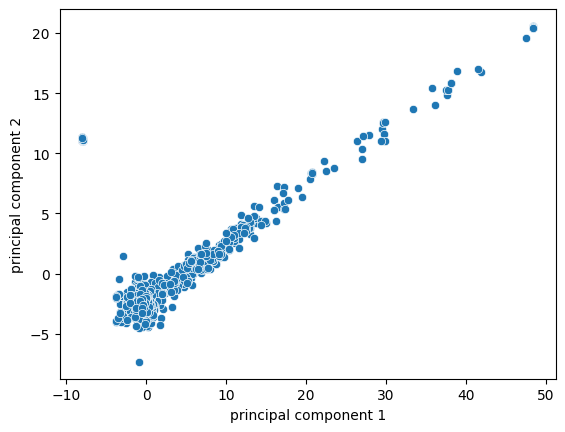

In [540]:
sns.scatterplot(principal['principal component 1'], principal['principal component 2'])

Теперь обучаем PCA+KMeans

Применим elbow method:

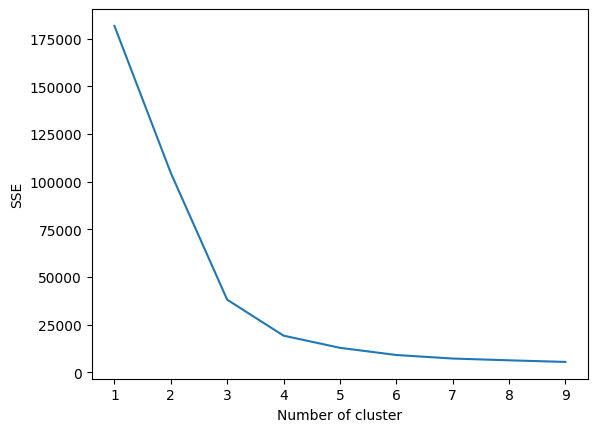

In [541]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

data = principal

sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
    data["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

Выберем число кластеров 8 (по графику elbow method такое число уже неприемлемо, при этом при нем метрика лучше).

In [597]:
kmeans = KMeans(n_clusters=7).fit(principal)
l = kmeans.labels_

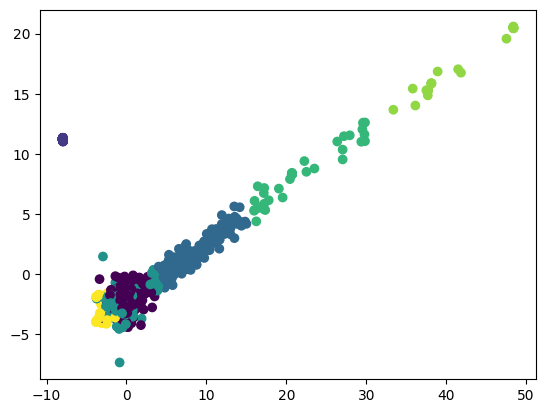

In [598]:
plt.scatter(principal['principal component 1'], 
             principal['principal component 2'],
             c=l,
           )

Оценим качество с помощью [silhouette score](https://stephenallwright.com/good-clustering-metrics/):

In [599]:
from sklearn import metrics
metrics.silhouette_score(principal,l)

0.8013291365934179

Теперь DBSCAN

0.7703928463549768

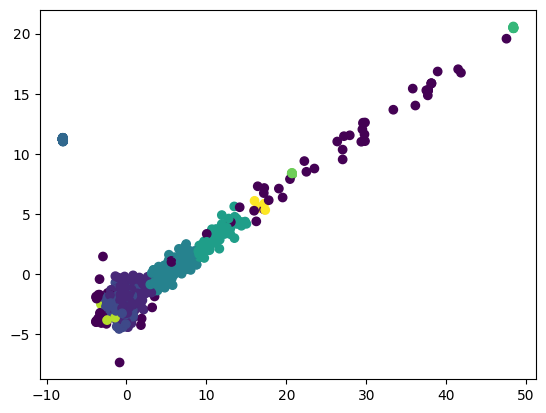

In [610]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=1.05, min_samples=6).fit(principal)
clustering.labels_
plt.scatter(principal['principal component 1'], 
             principal['principal component 2'],
             c=clustering.labels_,
           )
metrics.silhouette_score(principal,clustering.labels_)

Теперь Гауссовская смесь.

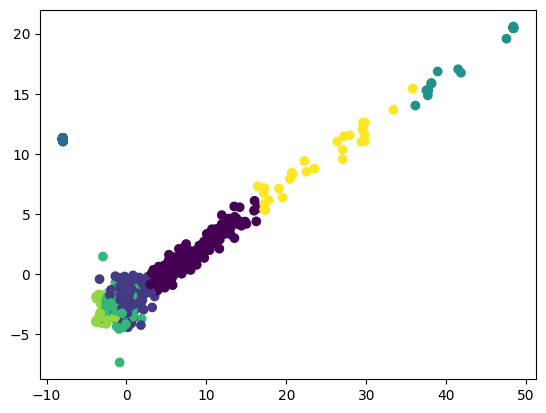

In [595]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=7, random_state=0).fit(principal)
gm.predict(principal)
plt.scatter(principal['principal component 1'], 
             principal['principal component 2'],
             c=gm.predict(principal),
           )

Путем перебора я получил, что именно при 6 кластерах достигается максимум метрики:

In [611]:
metrics.silhouette_score(principal,gm.predict(principal))

0.8000598290840241

Самым лучшим по метрике оказался KMeans. При этом график двумерной проекции выглядит наиболее адекватным нашим данным (кластеры выделены разумно).

In [612]:
df['clust'] = l

In [613]:
df.to_csv('resumes_features.csv')

**Анализ кластеров**

Самым лучшим оказался KMeans. Проанализируем наши данные, основываясь на его результатах.

In [614]:
df = pd.read_csv('resumes_features.csv')

In [615]:
df.drop(list(df)[0], axis=1, inplace=True)
df.reset_index(inplace=True)
df.drop(list(df)[0], axis=1, inplace=True)

In [616]:
df.sample(1)

,Ссылка,Название,Коммандировка,Опыт,О себе,Образование,Интересы,Навыки,Образование-1,Образование-2,...,93,94,95,96,97,98,99,clust,"DA, predicted","DS, predicted"
1587,https://hh.ru/resume/d8441f8400000c40a80039ed1...,"тестировщик, системный аналитик, технический п...","Москва, не готова к переезду, не готова к кома...",Опыт работы 26 лет 6 месяцев,Анализ бизнес-процессов предприятий различных ...,Высшее образование\n1985\nМосковский текстильн...,Специализации:\nТестировщик\nЗанятость: полная...,---,Московский текстильный институт,NaN,...,-0.008506,0.00417,0.001326,0.004055,-0.002272,0.001945,-0.004527,2,0.0,0.0


Что за кластеры:

In [617]:
df.loc[df['clust']==0]['О себе']

0       Уверенный пользователь ПК, Ms Word, Ms Excel, ...
1       Энергична, активна, в поиске новых возможносте...
4       Дисциплина - умение выполнять поставленные зад...
5       Банковская бухгалтерия. Технология банковских ...
6       Личные качества:\nВысокая способность усваиват...
                              ...                        
2710    Высокая способность к обучению, в частности к ...
2712    Разработанная мной методика перспективного вне...
2714    Опыт управления более 15-и лет. Развитые управ...
2715    Аналитика продаж ,поиск клиентов,связь с произ...
2720    Уверенный пользователь ПК: MS Office (Word, Ex...
Name: О себе, Length: 1329, dtype: object

In [618]:
df.loc[df['clust']==1]['О себе']

22      ---
31      ---
33      ---
34      ---
46      ---
       ... 
2711    ---
2716    ---
2717    ---
2723    ---
2724    ---
Name: О себе, Length: 356, dtype: object

In [619]:
df.loc[df['clust']==2]['О себе']

29      Разбираюсь в новых системах и проектах, люблю ...
32      Имею большой опыт в продажах. Работая в любом ...
76      Профессиональные навыки:\nExcel : сводные табл...
101     легко обучаема,целеустремленная,клиентоорентир...
109     - люблю много и результативно работать\n- ценю...
                              ...                        
2691    Обладание сильным потенциалом и энергетикой. Л...
2701    Пользователь MS Office (Word, Excel, Internet)...
2706    ответственная, коммуникабельная, работаю в усл...
2708    Сильный бэкграунд, опыт работы в различных сфе...
2721    Моя потребность в постоянном улучшении себя на...
Name: О себе, Length: 172, dtype: object

In [620]:
df.loc[df['clust']==3]['О себе']

2       опыт прямых продаж, ведение коммерческих перег...
3       Коммуникабелен\nУмение работать с возражениями...
8       Интересы:\nСпорт, маркетинг (digital-marketing...
11       навык аудита системы менеджмента, бизнес-про...
12      - Уверенный пользователь MS Office (Excel, VBA...
                              ...                        
2694    Ответственный, энергичный, общительный, собран...
2699    В последние годы проходил обучение без возможн...
2713    Молодой человек обладающий умением сконцентрир...
2719    Многозадачность, стрессоустойчивость, инициати...
2722                                                    .
Name: О себе, Length: 762, dtype: object

In [621]:
df.loc[df['clust']==4]['О себе']

128     Легко и быстро обучаюсь, целеустремленная, вни...
138     Нацелена на результат. В интересные проекты по...
513     • Умею и люблю учиться;\n• Пунктуальна и дисци...
588     Личные качества:\nАктивный, общительный, легко...
660     Личные качества:\nАктивный, общительный, легко...
661     Люблю ответственность и ответственных людей, п...
812     Гибкий и мобильный сотрудник, имею высокий уро...
842     - Аналитический склад ума;\n- Хорошие коммуник...
872     Молодой,Ответственный,Доброжелательный, способ...
891     Ответственная, целеустремленная, коммуникабель...
1020    Готова сразу приступить к работе.\n\nExcel- ув...
1076    Навыки работы на ПК: опытный пользователь (при...
1106    Коммуникабельная, ответственная, быстро обучае...
1150    Ответственный, честный, нацеленный на результа...
1175    На практике работаю с большими потоком докумен...
1284    Люблю путешествовать, 100 % коммуникабельность...
1287    Коммуникабельность, доброжелательность, работо...
1298    Имею о

In [623]:
df.loc[df['clust']==5]['О себе']

58      Общий стаж работы более 20 лет. Легко обучаюсь...
298     Добрый день. Немного обо мне: Успешное провиде...
336     Аналитический склад ума, высокая концентрация,...
376     Пунктуальная, исполнительная, мобильная.\nУмею...
593     Работал с людьми обладаю управлять командой зн...
759     Умею работать в режиме многозадачности, пункту...
1140    Люблю думать, создавать, видеть в своей работе...
1442    Здравствуйте, меня зовут Ксения.\nИз качеств о...
1493    Уравновешенный, целеустремленный, коммуникабел...
1556    Очень люблю автомобили, много читаю, в т.ч. те...
1595    Легко и быстро обучаюсь. Всегда стремлюсь узна...
1688    Имею опыт работы с web интерфейсами: backdase,...
1734    Активность, коммуникабельность, стрессоустойчи...
1908    Коммуникабельность,стрессоустойчивость,целеуст...
1958    Личные качества - целеустремленность, коммуник...
2016    Имею знания в области банковских технологий, и...
2041    Имею знания в области банковских технологий, и...
2131    Работа

In [624]:
df.loc[df['clust']==6]['О себе']

159     Увлечения: спорт, активный образ жизни.\nЛичны...
279     Интиллегентный, ответственный, целеустремлённы...
320     Способен решить в кратчайший срок все возникши...
321     Коммуникабельная, приятной наружности. Исполни...
411         Целеустремленный человек, с тягой познания...
486     Ответственный, стрессоустойчивый, креативный, ...
535     Ответственная, целеустремлённая, быстро схваты...
578     Ответственный, честный, усидчивый, стрессоусто...
618     Стремление к самообразованию. Требовательность...
623     Активная, увлекаюсь интеллектуальными играми, ...
624     Коммуникабелен, ответственен, настойчив в дост...
647     Аналитический, креативный склад ума, работоспо...
677                        Целеустремленная,пунктуальная.
707     туризм, спортивная рыбалка, книги, бадминтон.\...
717     Семейное положение: женат. дочь 9 лет.\nВодите...
754     Хоби, спорт, туризм, активный отдых, рыбалка о...
780     Аналитический склад ума, целеустремленный, раб...
817     личнос

In [622]:
for x in np.unique(df['clust']):
    print(x + 1, ':', df.loc[df['clust']==x]['О себе'].shape[0])

1 : 1329
2 : 356
3 : 172
4 : 762
5 : 41
6 : 25
7 : 40


In [637]:
from nltk import FreqDist

In [638]:
for x in np.unique(df['clust']):
    cluster_ind = df.loc[df['clust']==x]['О себе'].index
    cluster_tokens = []

    for i in cluster_ind:
        if df2.loc[i, 'О себе 3'] != None:
            cluster_tokens += df2.loc[i, 'О себе 3']

    print(i, ':', FreqDist(cluster_tokens).most_common(15))

2720 : [('настоящий время работать', 51), ('настоящий время заниматься', 40), ('умение работать команда', 32), ('находиться поиск работа', 30), ('иметь опыт работа', 29), ('опыт работа сфера', 26), ('данный момент работать', 23), ('уверенный пользователь пк', 21), ('опытный пользователь пк', 20), ('аналитический склад ум', 19), ('данный момент иметь', 18), ('время работать крупный', 18), ('данный момент являться', 18), ('заниматься информационный технология', 18), ('данный момент заниматься', 18)]
2724 : []
2721 : [('данный момент работать', 104), ('находиться поиск работа', 96), ('момент работать крупный', 31), ('работа данный момент', 29), ('поиск работа хотеть', 26), ('поиск работа данный', 25), ('поиск работа сфера', 16), ('момент работать самый', 16), ('момент работать сфера', 16), ('работа хотеть заполучить', 15), ('момент работать компания', 14), ('работать крупный россия', 13), ('работать компания который', 10), ('работать самый известный', 10), ('хотеть заполучить должность', 

In [640]:
for x in np.unique(df['clust']):
    print(x, ':\n', df.loc[df['clust']==x]['DA, predicted'].value_counts())

0 :
 0.0    1297
1.0      22
2.0      10
Name: DA, predicted, dtype: int64
1 :
 0.0    350
2.0      4
1.0      2
Name: DA, predicted, dtype: int64
2 :
 0.0    169
1.0      2
2.0      1
Name: DA, predicted, dtype: int64
3 :
 0.0    747
1.0     10
2.0      5
Name: DA, predicted, dtype: int64
4 :
 0.0    41
Name: DA, predicted, dtype: int64
5 :
 0.0    25
Name: DA, predicted, dtype: int64
6 :
 0.0    39
1.0     1
Name: DA, predicted, dtype: int64


['Кол-во образований',
 'Опыт нормализованный',
 'Топовость образования',
 'Справочник по интересам',
 'Релокация?',
 'Коммандировка?',
 'Город?',
 'Уровень оборазования нормализованный',
 'Карьерный рост',
 'Аналитические комбинации слов в навыках']

In [ ]:
for x in np.unique(df['clust']):
    for col in list(X)[101:]:
        print(x, ':\n', df.loc[df['clust']==x][col].value_counts())
        print(df.loc[df['clust']==x][col].describe())

0 :
 1     727
2     422
3     112
4      28
0      14
5      11
6       5
7       5
8       2
9       2
10      1
Name: Кол-во образований, dtype: int64
count    1329.000000
mean        1.642588
std         1.017627
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        10.000000
Name: Кол-во образований, dtype: float64
0 :
 -1.000000     25
 2.250000     11
 9.250000     10
 12.250000    10
 10.583333     9
              ..
 43.250000     1
 22.500000     1
 28.166667     1
 29.333333     1
 11.000000     1
Name: Опыт нормализованный, Length: 358, dtype: int64
count    1329.000000
mean       12.846125
std         8.461049
min        -1.000000
25%         6.250000
50%        12.166667
75%        18.333333
max        46.250000
Name: Опыт нормализованный, dtype: float64
0 :
 0    1176
1     153
Name: Топовость образования, dtype: int64
count    1329.000000
mean        0.115124
std         0.319292
min         0.000000
25%         0.000000
50%     